# 3. Factor investing and asset pricing anomalies

The first step is to activate the packages and load the data.

In [1]:
import pyreadr 
import pandas_datareader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime as dt
import calendar
from sklearn.linear_model import LinearRegression 
from scipy import stats

In [2]:
data_ml = pyreadr.read_r(# insert path of data_ml.RData) 
data_ml = data_ml["data_ml"]

In [3]:
data_ml.date = pd.to_datetime(data_ml.date)

data_ml = data_ml.loc[(data_ml['date'] > "1999-12-31") & (data_ml['date'] < "2019-01-01")]
data_ml.sort_values(by = ['stock_id','date'], inplace = True)
data_ml.iloc[0:6,:6]

,stock_id,date,Advt_12M_Usd,Advt_3M_Usd,Advt_6M_Usd,Asset_Turnover
177278,1,2000-01-31,0.41,0.39,0.42,0.19
177279,1,2000-02-29,0.41,0.39,0.40,0.19
182907,1,2000-03-31,0.40,0.37,0.37,0.20
182908,1,2000-04-30,0.39,0.36,0.37,0.20
182909,1,2000-05-31,0.40,0.42,0.40,0.20
182910,1,2000-06-30,0.41,0.47,0.42,0.21


We also duplicate the last chunk in Chapter 2.


In [4]:
stock_ids = data_ml.stock_id.unique()                                                                                           
stock_days = data_ml.stock_id.value_counts().sort_index()                                           
stock_ids_short = stock_ids[stock_days.values == max(stock_days.values)]                            
returns_short = data_ml[data_ml['stock_id'].isin(stock_ids_short)][['date','stock_id','R1M_Usd']]
returns = returns_short.pivot_table(index=['date'],columns='stock_id',values='R1M_Usd') 

In the code below, we compute size portfolios (equally weighted: above versus below the median capitalization). According to the size anomaly, the firms with below median market cap should earn higher returns on average. This is verified whenever the orange bar in the plot is above the blue one (it happens most of the time). 

<AxesSubplot:xlabel='year'>

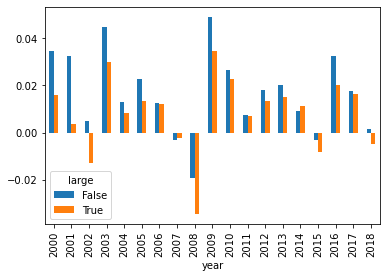

In [5]:
data_ml['year'] = data_ml.date.apply( lambda x: x.year)
data_ml['large'] = data_ml.Mkt_Cap_12M_Usd >  data_ml.groupby('date').Mkt_Cap_12M_Usd.transform('median')

data_ml.groupby(['year','large']).R1M_Usd.agg("mean").unstack("large").plot.bar() 

Below, we import data from Ken French's data library. We will use it later on in the chapter.

In [6]:
datasets = pandas_datareader.famafrench.get_available_datasets()
print('No. of datasets:{0}'.format(len(datasets))) #check data set 
datasets[:5]

No. of datasets:297


['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily']

In [7]:
min_date = "1963-07-31"
max_date = "2020-05-28"
FF_factors = pandas_datareader.data.DataReader("F-F_Research_Data_5_Factors_2x3",'famafrench', start = min_date , end = max_date)            
FF_factors[0].index = FF_factors[0].index.map(lambda x: dt.strptime(str(x),'%Y-%m').replace(day = calendar.monthrange(x.year, x.month)[1])) 
FF_factors = FF_factors[0]
FF_factors = FF_factors.apply(lambda x: x/100)                                                                                              
FF_factors.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
1963-07-31,-0.0039,-0.0047,-0.0083,0.0066,-0.0115,0.0027
1963-08-31,0.0507,-0.0079,0.0167,0.0040,-0.0040,0.0025
1963-09-30,-0.0157,-0.0048,0.0018,-0.0076,0.0024,0.0027
1963-10-31,0.0253,-0.0129,-0.0010,0.0275,-0.0224,0.0029
1963-11-30,-0.0085,-0.0084,0.0171,-0.0045,0.0222,0.0027


In the next figure, we plot the average monthly return aggregated over each calendar year for five common factors. 


<AxesSubplot:xlabel='date'>

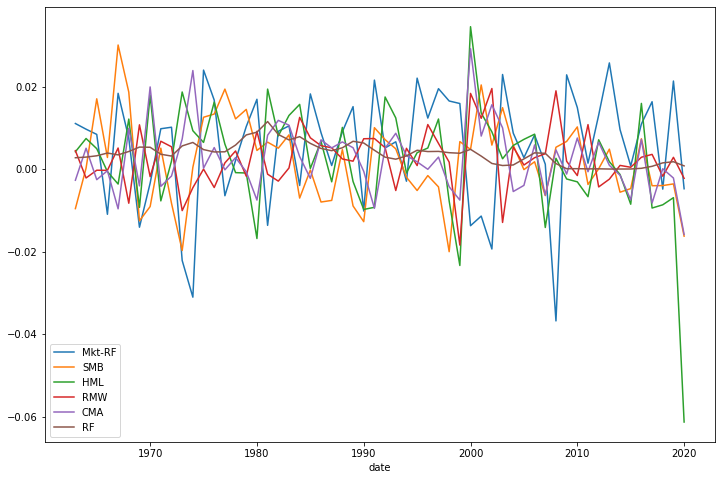

In [8]:
factor_average_return_list = []
for year, gp in FF_factors.groupby(FF_factors.index.year):
    factor_average_return_dict = {}
    factor_average_return_dict['date'] = year
    factor_average_return_dict['Mkt-RF'] = gp['Mkt-RF'].mean()
    factor_average_return_dict['SMB'] = gp['SMB'].mean()
    factor_average_return_dict['HML'] = gp['HML'].mean()    
    factor_average_return_dict['RMW'] = gp['RMW'].mean()
    factor_average_return_dict['CMA'] = gp['CMA'].mean()
    factor_average_return_dict['RF'] = gp['RF'].mean()    
    factor_average_return_list.append(factor_average_return_dict)

factor_average_return = pd.DataFrame(factor_average_return_list)
factor_average_return.set_index('date', inplace=True)
factor_average_return.plot(figsize=(12, 8), rot=0) 

Below, we perform Fama-French regressions on our sample.

In [9]:
nb_factors = 5

data_ml_short = data_ml[data_ml['stock_id'].isin(stock_ids_short)]
data_ml_short.sort_values(by=['stock_id','date'], ascending=True, inplace=True)
data_ml_short['R1M_Usd'] = data_ml_short.sort_values(by='date', ascending=True).groupby('stock_id')['R1M_Usd'].shift(1)  # Lag returns
data_ml_short.dropna(inplace=True)                                                                                       # Remove missing points
data_ml_short = data_ml_short.pivot(index='date', columns='stock_id',values='R1M_Usd')

C:\Users\minho\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\minho\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\minho\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
data_FF_5 = pd.merge(data_ml_short, FF_factors, how='left', 
                        left_index= True, right_index = True)

In [11]:
X = data_FF_5[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].to_numpy()
y = data_FF_5[stock_ids_short].to_numpy()

reg = LinearRegression()
reg.fit(X, y)
# The coefficients
print('Coefficients: \n', reg.coef_)

Coefficients: 
 [[ 1.43087976  0.52374242  0.63443833  0.99781455 -0.39699299]
 [ 0.82845279  1.10063941  0.88956137  0.31021805 -0.54133191]
 [ 0.3623874   0.298234   -0.04868912  0.58735313  0.20157337]
 ...
 [ 1.22405955  0.05867802  0.24201407  0.57674646 -0.30748853]
 [ 0.61341296  0.41638623  0.28486988  0.37479002  0.09812847]
 [ 2.1534563   1.06316372  0.77896018  0.47097358  0.46543971]]


In [12]:
betas = pd.DataFrame(reg.coef_, columns=['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'])
betas.index = stock_ids_short
betas.head()

,Mkt-RF,SMB,HML,RMW,CMA
1,1.430880,0.523742,0.634438,0.997815,-0.396993
3,0.828453,1.100639,0.889561,0.310218,-0.541332
4,0.362387,0.298234,-0.048689,0.587353,0.201573
7,0.424303,0.680989,0.255402,0.309364,0.116079
9,0.842766,0.662656,1.075435,0.041718,0.051901


In the table, *MKT_RF* is the market return minus the risk free rate. We then reformat these betas to prepare the second pass. Each line corresponds to one asset: the first 5 columns are the estimated factor loadings and the remaining ones are the asset returns (date by date).

In [13]:
loadings = betas
FM_data = loadings.merge(returns.T, how='left', left_index=True, 
                               right_index=True)
FM_data.head()

,Mkt-RF,SMB,HML,RMW,CMA,2000-01-31 00:00:00,2000-02-29 00:00:00,2000-03-31 00:00:00,2000-04-30 00:00:00,2000-05-31 00:00:00,...,2018-03-31 00:00:00,2018-04-30 00:00:00,2018-05-31 00:00:00,2018-06-30 00:00:00,2018-07-31 00:00:00,2018-08-31 00:00:00,2018-09-30 00:00:00,2018-10-31 00:00:00,2018-11-30 00:00:00,2018-12-31 00:00:00
1,1.430880,0.523742,0.634438,0.997815,-0.396993,-0.036,0.263,0.031,0.448,-0.097,...,0.173,-0.042,-0.038,0.000,-0.077,-0.002,-0.155,0.014,-0.110,0.082
3,0.828453,1.100639,0.889561,0.310218,-0.541332,0.077,-0.024,0.018,0.027,0.050,...,-0.039,0.030,-0.028,-0.039,0.033,-0.049,-0.070,0.036,-0.070,0.030
4,0.362387,0.298234,-0.048689,0.587353,0.201573,-0.016,0.000,0.153,-0.011,0.014,...,0.071,-0.024,0.059,0.029,-0.004,0.036,-0.025,0.000,-0.088,0.043
7,0.424303,0.680989,0.255402,0.309364,0.116079,-0.009,0.027,0.000,-0.017,0.018,...,0.030,0.100,0.036,-0.005,0.022,-0.068,-0.052,0.007,-0.066,0.131
9,0.842766,0.662656,1.075435,0.041718,0.051901,0.032,0.076,-0.025,-0.022,-0.121,...,0.046,0.047,0.000,0.064,-0.137,-0.028,-0.098,-0.018,-0.099,0.112


We observe that the values of the first column (market betas) revolve around one, which is what we would expect. 
Finally, we are ready for the second round of regressions. 

In [14]:
X = FM_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].to_numpy()
y = FM_data[returns.index].to_numpy()

loadings_reg = LinearRegression()
loadings_reg.fit(X, y)
gammas = loadings_reg.coef_
gammas = pd.DataFrame(gammas, columns=['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'])
gammas.index = returns.index
gammas.head()

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2000-01-31,0.042797,0.217570,-0.137015,-0.271884,0.034571
2000-02-29,0.076712,-0.129546,0.044421,0.085677,-0.027268
2000-03-31,-0.011477,-0.014058,0.052387,0.038771,0.042647
2000-04-30,-0.153988,-0.103667,0.157166,0.077962,-0.057640
2000-05-31,-0.009040,0.071651,-0.096466,-0.092811,-0.053810


Visually, the estimated premia are also very volatile. We plot their estimated values for the market, SMB and HML factors.

<AxesSubplot:xlabel='date'>

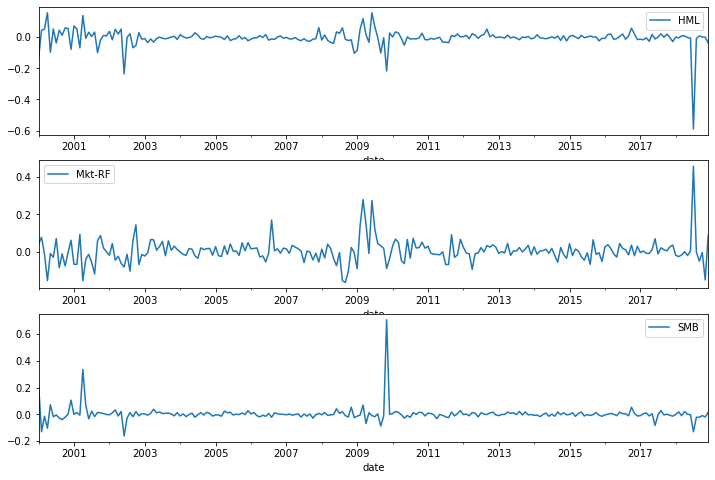

In [15]:
fig, axes = plt.subplots(nrows=3, figsize=(12, 8))

gammas[['HML']].plot(ax=axes[0])
gammas[['Mkt-RF']].plot(ax=axes[1])
gammas[['SMB']].plot(ax=axes[2])

The chunk below tests factor competition: each factor is regressed against all other factors.

In [16]:

def get_p_value(reg, X, y):
    params = np.append(reg.intercept_,reg.coef_)
    predictions = reg.predict(X)

    newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)

    df = pd.DataFrame()
    df["Coefficients"],df["Standard Errors"],df["t values"],df["Probabilites"] = [params,sd_b,ts_b,p_values]
    print(df)
    
    return True

In [17]:
for i, col in enumerate(FF_factors.columns[:-1]):
    print(col)
    selected_col = FF_factors.columns.tolist()[:-1]
    selected_col.pop(i)
    
    X = FF_factors[selected_col].to_numpy()
    y = FF_factors[col].to_numpy()
    
    Factor_Competiton_reg = LinearRegression()
    Factor_Competiton_reg.fit(X, y)    
    
    get_p_value(Factor_Competiton_reg, X, y)

Mkt-RF
   Coefficients  Standard Errors  t values  Probabilites
0        0.0077            0.002     4.996         0.000
1        0.2874            0.053     5.388         0.000
2        0.1379            0.073     1.900         0.058
3       -0.3254            0.075    -4.366         0.000
4       -0.9472            0.105    -9.028         0.000
SMB
   Coefficients  Standard Errors  t values  Probabilites
0        0.0025            0.001     2.313         0.021
1        0.1429            0.027     5.388         0.000
2        0.1077            0.051     2.106         0.036
3       -0.4232            0.051    -8.340         0.000
4       -0.1533            0.078    -1.963         0.050
HML
   Coefficients  Standard Errors  t values  Probabilites
0       -0.0008            0.001    -0.996         0.319
1        0.0384            0.020     1.900         0.058
2        0.0603            0.029     2.106         0.036
3        0.1779            0.039     4.528         0.000
4        1.0331 